In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!ls

'Copy of FasterRCNN_112_112_mobilenet_v3_large_320_fpn.ipynb'
'Copy of INM707-Lab7-REINFORCE.ipynb'
'Copy of INM707-Lab8-DoubleDQN.ipynb'
'Copy of INM707-Lab9-AC-PPO.ipynb'
 FasterRCNN_112_112_faster_weights_adam.ipynb
 FasterRCNN_112_112_faster_weights.ipynb
 FasterRCNN_config.ipynb
 FasterRCNN.ipynb
 FrCNN_config.ipynb
 fruit-images-for-object-detection
 INFERECE_INM705Lab3_object_dection.ipynb
 Inference_Load_Checkpoints.ipynb
 INM705
'INM705_lab1_showcase (1).ipynb'
 INM705_lab1_showcase.ipynb
'INM705_W7 - Graph Networks.ipynb'
 INM706_CW_from_PyCharm.ipynb
 INM706_W7_Bert
 INM707-Lab6
 Lab4_FCN_MASK_RCNN_Inference.ipynb
'Load of FasterRCNN checkpoint.ipynb'
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 wandb


In [55]:
%cd /content/drive/MyDrive/Colab\ Notebooks
!ls


/content/drive/MyDrive/Colab Notebooks
'Copy of FasterRCNN_112_112_mobilenet_v3_large_320_fpn.ipynb'
'Copy of INM707-Lab7-REINFORCE.ipynb'
'Copy of INM707-Lab8-DoubleDQN.ipynb'
'Copy of INM707-Lab9-AC-PPO.ipynb'
 FasterRCNN_112_112_faster_weights_adam.ipynb
 FasterRCNN_112_112_faster_weights.ipynb
 FasterRCNN_config.ipynb
 FasterRCNN.ipynb
 FrCNN_config.ipynb
 fruit-images-for-object-detection
 INFERECE_INM705Lab3_object_dection.ipynb
 Inference_Load_Checkpoints.ipynb
 INM705
'INM705_lab1_showcase (1).ipynb'
 INM705_lab1_showcase.ipynb
'INM705_W7 - Graph Networks.ipynb'
 INM706_CW_from_PyCharm.ipynb
 INM706_W7_Bert
 INM707-Lab6
 Lab4_FCN_MASK_RCNN_Inference.ipynb
'Load of FasterRCNN checkpoint.ipynb'
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 wandb


In [56]:
!pip install -q torch_snippets
!pip3 install wandb -qU
from torch_snippets import *
import torch
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
import numpy as np
import wandb
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda

In [57]:
# get parameters from config file
import yaml

def read_settings(config_path):
    with open(config_path, 'r') as file:
        settings = yaml.safe_load(file)
    return settings


# Read settings from the YAML file
root_path = 'fruit-images-for-object-detection/'
config_path = root_path + 'config.yaml'
settings = read_settings(config_path)

path_settings = settings.get('path_settings', {})
model_settings = settings.get('model', {})
train_settings = settings.get('train', {})

print("backbone",model_settings['backbone'])
print("Optimizer",model_settings['optimizer'])
print("Learning Rate",train_settings['learning_rate'])
print("Image size",train_settings['image_size'])

backbone RESNET

Optimizer ADAM

Learning Rate 1e-05

Image size 112

In [58]:
# Get saved checkpoints
checkpoint = path_settings['checkpoint_root'] + model_settings['backbone'] + "_" + model_settings['optimizer'] + "_lr_" + str(train_settings['learning_rate']) + "_CKPT.pth"
print(checkpoint)

fruit-images-for-object-detection/checkpoints/RESNET_ADAM_lr_1e-05_CKPT.pth

In [59]:
# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

def get_model():
  if model_settings['backbone'] == "RESNET":
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
  elif model_settings['backbone'] == "MOBILENET":
    model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

def load_checkpoint(model, file_name):
    ckpt = torch.load(file_name, map_location=device)
    model_weights = ckpt['model_weights']
    model.load_state_dict(model_weights)
    print("Model's pretrained weights loaded!")

model = get_model().to(device)


#load_checkpoint(model, checkpoint)


state_dict = torch.load(checkpoint, map_location=torch.device(device))

for k, par in state_dict.items():
    if k in model.state_dict().keys() and par.size() == model.state_dict()[k].size():

        model.state_dict()[k].copy_(par)
        print(f'copied weights for {k}')
    else:
        print("Weight dimensions mismatch for {}".format(k))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


copied weights for backbone.body.conv1.weight

copied weights for backbone.body.bn1.weight

copied weights for backbone.body.bn1.bias

copied weights for backbone.body.bn1.running_mean

copied weights for backbone.body.bn1.running_var

copied weights for backbone.body.layer1.0.conv1.weight

copied weights for backbone.body.layer1.0.bn1.weight

copied weights for backbone.body.layer1.0.bn1.bias

copied weights for backbone.body.layer1.0.bn1.running_mean

copied weights for backbone.body.layer1.0.bn1.running_var

copied weights for backbone.body.layer1.0.conv2.weight

copied weights for backbone.body.layer1.0.bn2.weight

copied weights for backbone.body.layer1.0.bn2.bias

copied weights for backbone.body.layer1.0.bn2.running_mean

copied weights for backbone.body.layer1.0.bn2.running_var

copied weights for backbone.body.layer1.0.conv3.weight

copied weights for backbone.body.layer1.0.bn3.weight

copied weights for backbone.body.layer1.0.bn3.bias

copied weights for backbone.body.layer1.0.bn3.running_mean

copied weights for backbone.body.layer1.0.bn3.running_var

copied weights for backbone.body.layer1.0.downsample.0.weight

copied weights for backbone.body.layer1.0.downsample.1.weight

copied weights for backbone.body.layer1.0.downsample.1.bias

copied weights for backbone.body.layer1.0.downsample.1.running_mean

copied weights for backbone.body.layer1.0.downsample.1.running_var

copied weights for backbone.body.layer1.1.conv1.weight

copied weights for backbone.body.layer1.1.bn1.weight

copied weights for backbone.body.layer1.1.bn1.bias

copied weights for backbone.body.layer1.1.bn1.running_mean

copied weights for backbone.body.layer1.1.bn1.running_var

copied weights for backbone.body.layer1.1.conv2.weight

copied weights for backbone.body.layer1.1.bn2.weight

copied weights for backbone.body.layer1.1.bn2.bias

copied weights for backbone.body.layer1.1.bn2.running_mean

copied weights for backbone.body.layer1.1.bn2.running_var

copied weights for backbone.body.layer1.1.conv3.weight

copied weights for backbone.body.layer1.1.bn3.weight

copied weights for backbone.body.layer1.1.bn3.bias

copied weights for backbone.body.layer1.1.bn3.running_mean

copied weights for backbone.body.layer1.1.bn3.running_var

copied weights for backbone.body.layer1.2.conv1.weight

copied weights for backbone.body.layer1.2.bn1.weight

copied weights for backbone.body.layer1.2.bn1.bias

copied weights for backbone.body.layer1.2.bn1.running_mean

copied weights for backbone.body.layer1.2.bn1.running_var

copied weights for backbone.body.layer1.2.conv2.weight

copied weights for backbone.body.layer1.2.bn2.weight

copied weights for backbone.body.layer1.2.bn2.bias

copied weights for backbone.body.layer1.2.bn2.running_mean

copied weights for backbone.body.layer1.2.bn2.running_var

copied weights for backbone.body.layer1.2.conv3.weight

copied weights for backbone.body.layer1.2.bn3.weight

copied weights for backbone.body.layer1.2.bn3.bias

copied weights for backbone.body.layer1.2.bn3.running_mean

copied weights for backbone.body.layer1.2.bn3.running_var

copied weights for backbone.body.layer2.0.conv1.weight

copied weights for backbone.body.layer2.0.bn1.weight

copied weights for backbone.body.layer2.0.bn1.bias

copied weights for backbone.body.layer2.0.bn1.running_mean

copied weights for backbone.body.layer2.0.bn1.running_var

copied weights for backbone.body.layer2.0.conv2.weight

copied weights for backbone.body.layer2.0.bn2.weight

copied weights for backbone.body.layer2.0.bn2.bias

copied weights for backbone.body.layer2.0.bn2.running_mean

copied weights for backbone.body.layer2.0.bn2.running_var

copied weights for backbone.body.layer2.0.conv3.weight

copied weights for backbone.body.layer2.0.bn3.weight

copied weights for backbone.body.layer2.0.bn3.bias

copied weights for backbone.body.layer2.0.bn3.running_mean

copied weights for backbone.body.layer2.0.bn3.running_var

copied weights for backbone.body.layer2.0.downsample.0.weight

copied weights for backbone.body.layer2.0.downsample.1.weight

copied weights for backbone.body.layer2.0.downsample.1.bias

copied weights for backbone.body.layer2.0.downsample.1.running_mean

copied weights for backbone.body.layer2.0.downsample.1.running_var

copied weights for backbone.body.layer2.1.conv1.weight

copied weights for backbone.body.layer2.1.bn1.weight

copied weights for backbone.body.layer2.1.bn1.bias

copied weights for backbone.body.layer2.1.bn1.running_mean

copied weights for backbone.body.layer2.1.bn1.running_var

copied weights for backbone.body.layer2.1.conv2.weight

copied weights for backbone.body.layer2.1.bn2.weight

copied weights for backbone.body.layer2.1.bn2.bias

copied weights for backbone.body.layer2.1.bn2.running_mean

copied weights for backbone.body.layer2.1.bn2.running_var

copied weights for backbone.body.layer2.1.conv3.weight

copied weights for backbone.body.layer2.1.bn3.weight

copied weights for backbone.body.layer2.1.bn3.bias

copied weights for backbone.body.layer2.1.bn3.running_mean

copied weights for backbone.body.layer2.1.bn3.running_var

copied weights for backbone.body.layer2.2.conv1.weight

copied weights for backbone.body.layer2.2.bn1.weight

copied weights for backbone.body.layer2.2.bn1.bias

copied weights for backbone.body.layer2.2.bn1.running_mean

copied weights for backbone.body.layer2.2.bn1.running_var

copied weights for backbone.body.layer2.2.conv2.weight

copied weights for backbone.body.layer2.2.bn2.weight

copied weights for backbone.body.layer2.2.bn2.bias

copied weights for backbone.body.layer2.2.bn2.running_mean

copied weights for backbone.body.layer2.2.bn2.running_var

copied weights for backbone.body.layer2.2.conv3.weight

copied weights for backbone.body.layer2.2.bn3.weight

copied weights for backbone.body.layer2.2.bn3.bias

copied weights for backbone.body.layer2.2.bn3.running_mean

copied weights for backbone.body.layer2.2.bn3.running_var

copied weights for backbone.body.layer2.3.conv1.weight

copied weights for backbone.body.layer2.3.bn1.weight

copied weights for backbone.body.layer2.3.bn1.bias

copied weights for backbone.body.layer2.3.bn1.running_mean

copied weights for backbone.body.layer2.3.bn1.running_var

copied weights for backbone.body.layer2.3.conv2.weight

copied weights for backbone.body.layer2.3.bn2.weight

copied weights for backbone.body.layer2.3.bn2.bias

copied weights for backbone.body.layer2.3.bn2.running_mean

copied weights for backbone.body.layer2.3.bn2.running_var

copied weights for backbone.body.layer2.3.conv3.weight

copied weights for backbone.body.layer2.3.bn3.weight

copied weights for backbone.body.layer2.3.bn3.bias

copied weights for backbone.body.layer2.3.bn3.running_mean

copied weights for backbone.body.layer2.3.bn3.running_var

copied weights for backbone.body.layer3.0.conv1.weight

copied weights for backbone.body.layer3.0.bn1.weight

copied weights for backbone.body.layer3.0.bn1.bias

copied weights for backbone.body.layer3.0.bn1.running_mean

copied weights for backbone.body.layer3.0.bn1.running_var

copied weights for backbone.body.layer3.0.conv2.weight

copied weights for backbone.body.layer3.0.bn2.weight

copied weights for backbone.body.layer3.0.bn2.bias

copied weights for backbone.body.layer3.0.bn2.running_mean

copied weights for backbone.body.layer3.0.bn2.running_var

copied weights for backbone.body.layer3.0.conv3.weight

copied weights for backbone.body.layer3.0.bn3.weight

copied weights for backbone.body.layer3.0.bn3.bias

copied weights for backbone.body.layer3.0.bn3.running_mean

copied weights for backbone.body.layer3.0.bn3.running_var

copied weights for backbone.body.layer3.0.downsample.0.weight

copied weights for backbone.body.layer3.0.downsample.1.weight

copied weights for backbone.body.layer3.0.downsample.1.bias

copied weights for backbone.body.layer3.0.downsample.1.running_mean

copied weights for backbone.body.layer3.0.downsample.1.running_var

copied weights for backbone.body.layer3.1.conv1.weight

copied weights for backbone.body.layer3.1.bn1.weight

copied weights for backbone.body.layer3.1.bn1.bias

copied weights for backbone.body.layer3.1.bn1.running_mean

copied weights for backbone.body.layer3.1.bn1.running_var

copied weights for backbone.body.layer3.1.conv2.weight

copied weights for backbone.body.layer3.1.bn2.weight

copied weights for backbone.body.layer3.1.bn2.bias

copied weights for backbone.body.layer3.1.bn2.running_mean

copied weights for backbone.body.layer3.1.bn2.running_var

copied weights for backbone.body.layer3.1.conv3.weight

copied weights for backbone.body.layer3.1.bn3.weight

copied weights for backbone.body.layer3.1.bn3.bias

copied weights for backbone.body.layer3.1.bn3.running_mean

copied weights for backbone.body.layer3.1.bn3.running_var

copied weights for backbone.body.layer3.2.conv1.weight

copied weights for backbone.body.layer3.2.bn1.weight

copied weights for backbone.body.layer3.2.bn1.bias

copied weights for backbone.body.layer3.2.bn1.running_mean

copied weights for backbone.body.layer3.2.bn1.running_var

copied weights for backbone.body.layer3.2.conv2.weight

copied weights for backbone.body.layer3.2.bn2.weight

copied weights for backbone.body.layer3.2.bn2.bias

copied weights for backbone.body.layer3.2.bn2.running_mean

copied weights for backbone.body.layer3.2.bn2.running_var

copied weights for backbone.body.layer3.2.conv3.weight

copied weights for backbone.body.layer3.2.bn3.weight

copied weights for backbone.body.layer3.2.bn3.bias

copied weights for backbone.body.layer3.2.bn3.running_mean

copied weights for backbone.body.layer3.2.bn3.running_var

copied weights for backbone.body.layer3.3.conv1.weight

copied weights for backbone.body.layer3.3.bn1.weight

copied weights for backbone.body.layer3.3.bn1.bias

copied weights for backbone.body.layer3.3.bn1.running_mean

copied weights for backbone.body.layer3.3.bn1.running_var

copied weights for backbone.body.layer3.3.conv2.weight

copied weights for backbone.body.layer3.3.bn2.weight

copied weights for backbone.body.layer3.3.bn2.bias

copied weights for backbone.body.layer3.3.bn2.running_mean

copied weights for backbone.body.layer3.3.bn2.running_var

copied weights for backbone.body.layer3.3.conv3.weight

copied weights for backbone.body.layer3.3.bn3.weight

copied weights for backbone.body.layer3.3.bn3.bias

copied weights for backbone.body.layer3.3.bn3.running_mean

copied weights for backbone.body.layer3.3.bn3.running_var

copied weights for backbone.body.layer3.4.conv1.weight

copied weights for backbone.body.layer3.4.bn1.weight

copied weights for backbone.body.layer3.4.bn1.bias

copied weights for backbone.body.layer3.4.bn1.running_mean

copied weights for backbone.body.layer3.4.bn1.running_var

copied weights for backbone.body.layer3.4.conv2.weight

copied weights for backbone.body.layer3.4.bn2.weight

copied weights for backbone.body.layer3.4.bn2.bias

copied weights for backbone.body.layer3.4.bn2.running_mean

copied weights for backbone.body.layer3.4.bn2.running_var

copied weights for backbone.body.layer3.4.conv3.weight

copied weights for backbone.body.layer3.4.bn3.weight

copied weights for backbone.body.layer3.4.bn3.bias

copied weights for backbone.body.layer3.4.bn3.running_mean

copied weights for backbone.body.layer3.4.bn3.running_var

copied weights for backbone.body.layer3.5.conv1.weight

copied weights for backbone.body.layer3.5.bn1.weight

copied weights for backbone.body.layer3.5.bn1.bias

copied weights for backbone.body.layer3.5.bn1.running_mean

copied weights for backbone.body.layer3.5.bn1.running_var

copied weights for backbone.body.layer3.5.conv2.weight

copied weights for backbone.body.layer3.5.bn2.weight

copied weights for backbone.body.layer3.5.bn2.bias

copied weights for backbone.body.layer3.5.bn2.running_mean

copied weights for backbone.body.layer3.5.bn2.running_var

copied weights for backbone.body.layer3.5.conv3.weight

copied weights for backbone.body.layer3.5.bn3.weight

copied weights for backbone.body.layer3.5.bn3.bias

copied weights for backbone.body.layer3.5.bn3.running_mean

copied weights for backbone.body.layer3.5.bn3.running_var

copied weights for backbone.body.layer4.0.conv1.weight

copied weights for backbone.body.layer4.0.bn1.weight

copied weights for backbone.body.layer4.0.bn1.bias

copied weights for backbone.body.layer4.0.bn1.running_mean

copied weights for backbone.body.layer4.0.bn1.running_var

copied weights for backbone.body.layer4.0.conv2.weight

copied weights for backbone.body.layer4.0.bn2.weight

copied weights for backbone.body.layer4.0.bn2.bias

copied weights for backbone.body.layer4.0.bn2.running_mean

copied weights for backbone.body.layer4.0.bn2.running_var

copied weights for backbone.body.layer4.0.conv3.weight

copied weights for backbone.body.layer4.0.bn3.weight

copied weights for backbone.body.layer4.0.bn3.bias

copied weights for backbone.body.layer4.0.bn3.running_mean

copied weights for backbone.body.layer4.0.bn3.running_var

copied weights for backbone.body.layer4.0.downsample.0.weight

copied weights for backbone.body.layer4.0.downsample.1.weight

copied weights for backbone.body.layer4.0.downsample.1.bias

copied weights for backbone.body.layer4.0.downsample.1.running_mean

copied weights for backbone.body.layer4.0.downsample.1.running_var

copied weights for backbone.body.layer4.1.conv1.weight

copied weights for backbone.body.layer4.1.bn1.weight

copied weights for backbone.body.layer4.1.bn1.bias

copied weights for backbone.body.layer4.1.bn1.running_mean

copied weights for backbone.body.layer4.1.bn1.running_var

copied weights for backbone.body.layer4.1.conv2.weight

copied weights for backbone.body.layer4.1.bn2.weight

copied weights for backbone.body.layer4.1.bn2.bias

copied weights for backbone.body.layer4.1.bn2.running_mean

copied weights for backbone.body.layer4.1.bn2.running_var

copied weights for backbone.body.layer4.1.conv3.weight

copied weights for backbone.body.layer4.1.bn3.weight

copied weights for backbone.body.layer4.1.bn3.bias

copied weights for backbone.body.layer4.1.bn3.running_mean

copied weights for backbone.body.layer4.1.bn3.running_var

copied weights for backbone.body.layer4.2.conv1.weight

copied weights for backbone.body.layer4.2.bn1.weight

copied weights for backbone.body.layer4.2.bn1.bias

copied weights for backbone.body.layer4.2.bn1.running_mean

copied weights for backbone.body.layer4.2.bn1.running_var

copied weights for backbone.body.layer4.2.conv2.weight

copied weights for backbone.body.layer4.2.bn2.weight

copied weights for backbone.body.layer4.2.bn2.bias

copied weights for backbone.body.layer4.2.bn2.running_mean

copied weights for backbone.body.layer4.2.bn2.running_var

copied weights for backbone.body.layer4.2.conv3.weight

copied weights for backbone.body.layer4.2.bn3.weight

copied weights for backbone.body.layer4.2.bn3.bias

copied weights for backbone.body.layer4.2.bn3.running_mean

copied weights for backbone.body.layer4.2.bn3.running_var

copied weights for backbone.fpn.inner_blocks.0.0.weight

copied weights for backbone.fpn.inner_blocks.0.0.bias

copied weights for backbone.fpn.inner_blocks.1.0.weight

copied weights for backbone.fpn.inner_blocks.1.0.bias

copied weights for backbone.fpn.inner_blocks.2.0.weight

copied weights for backbone.fpn.inner_blocks.2.0.bias

copied weights for backbone.fpn.inner_blocks.3.0.weight

copied weights for backbone.fpn.inner_blocks.3.0.bias

copied weights for backbone.fpn.layer_blocks.0.0.weight

copied weights for backbone.fpn.layer_blocks.0.0.bias

copied weights for backbone.fpn.layer_blocks.1.0.weight

copied weights for backbone.fpn.layer_blocks.1.0.bias

copied weights for backbone.fpn.layer_blocks.2.0.weight

copied weights for backbone.fpn.layer_blocks.2.0.bias

copied weights for backbone.fpn.layer_blocks.3.0.weight

copied weights for backbone.fpn.layer_blocks.3.0.bias

copied weights for rpn.head.conv.0.0.weight

copied weights for rpn.head.conv.0.0.bias

copied weights for rpn.head.cls_logits.weight

copied weights for rpn.head.cls_logits.bias

copied weights for rpn.head.bbox_pred.weight

copied weights for rpn.head.bbox_pred.bias

copied weights for roi_heads.box_head.fc6.weight

copied weights for roi_heads.box_head.fc6.bias

copied weights for roi_heads.box_head.fc7.weight

copied weights for roi_heads.box_head.fc7.bias

copied weights for roi_heads.box_predictor.cls_score.weight

copied weights for roi_heads.box_predictor.cls_score.bias

copied weights for roi_heads.box_predictor.bbox_pred.weight

copied weights for roi_heads.box_predictor.bbox_pred.bias

In [60]:
root = path_settings['train_root']
val_root = path_settings['val_root']

# we have four labels
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)


batch_size_train = train_settings['batch_size_train']
batch_size_val = train_settings['batch_size_val']
learning_rate = train_settings['learning_rate']
weight_decay = train_settings['weight_decay']

def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

class FruitsDataset(Dataset):
    def __init__(self, root=root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xml_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        w = train_settings['image_size']
        h = train_settings['image_size']
        img_path = self.img_paths[idx]
        xml_path = self.xml_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h), resample=Image.BILINEAR))/255.
        xml = et.parse(xml_path)
        objects = xml.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))



val_ds = FruitsDataset(root=val_root)
val_dl = DataLoader(val_ds, batch_size=batch_size_val, shuffle=True, collate_fn=val_ds.collate_fn)

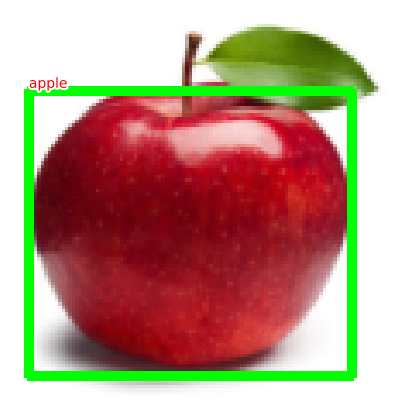

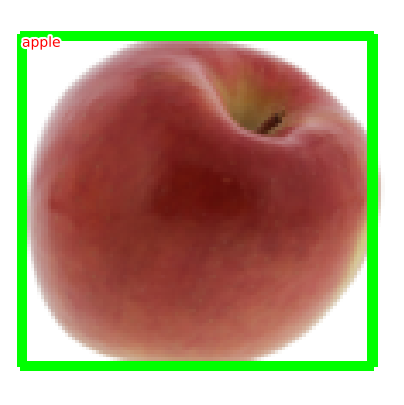

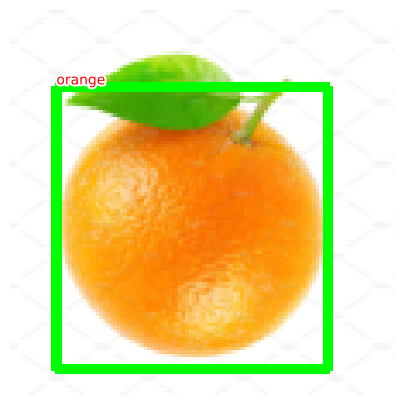

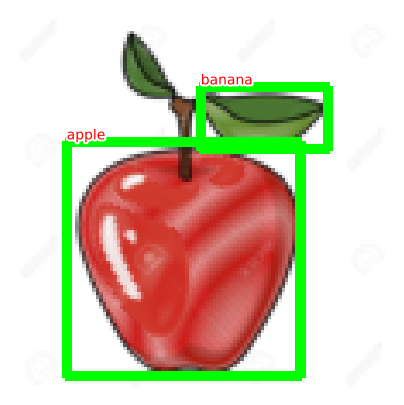

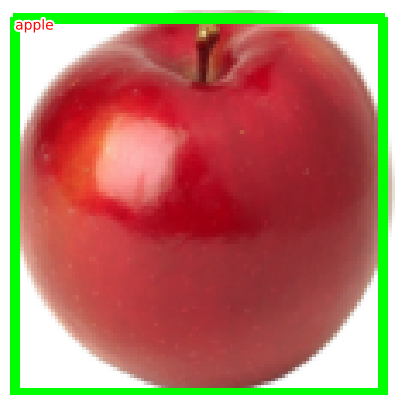

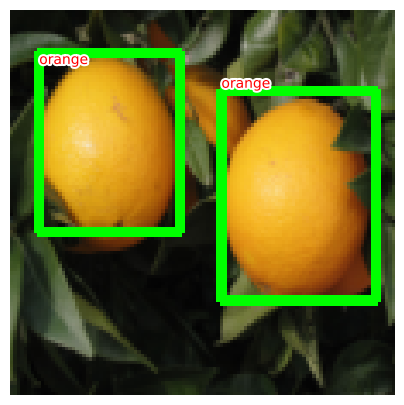

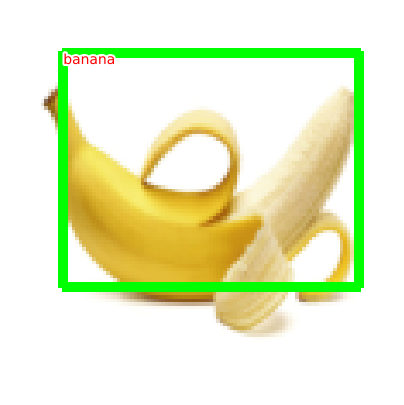

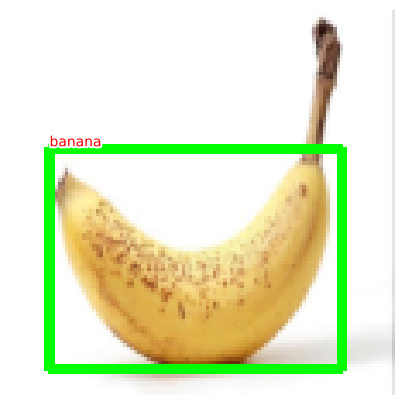

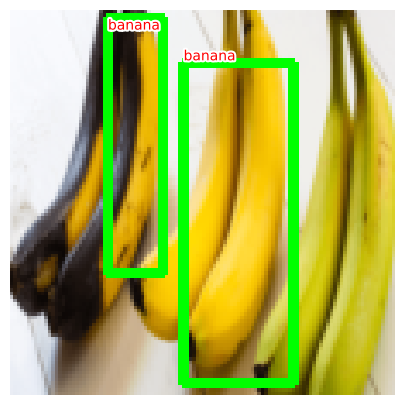

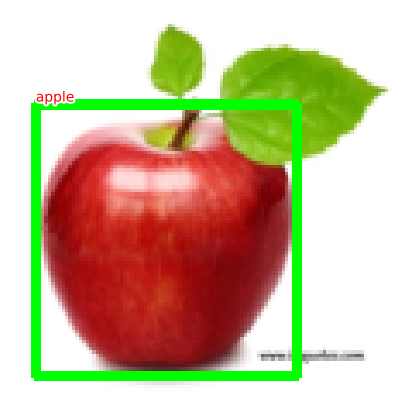

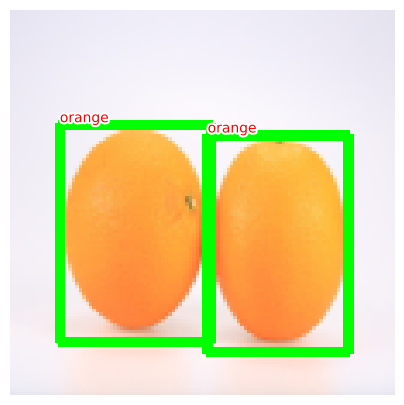

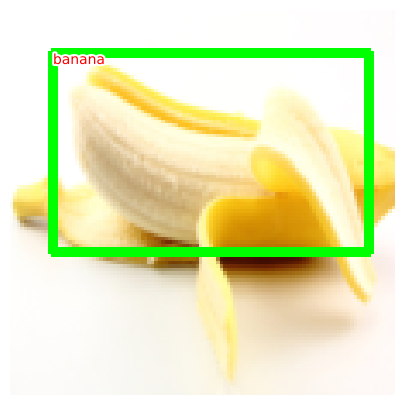

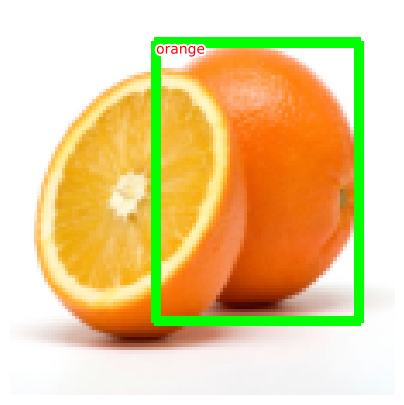

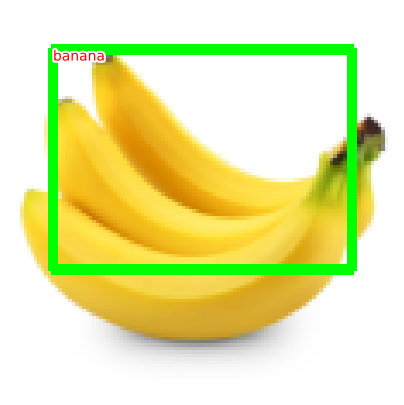

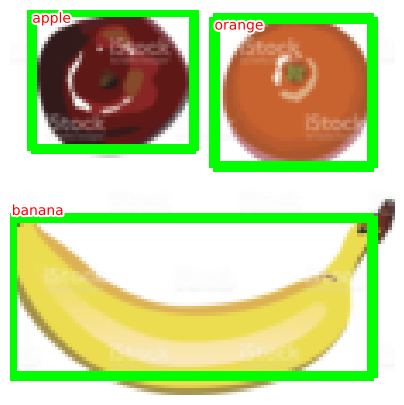

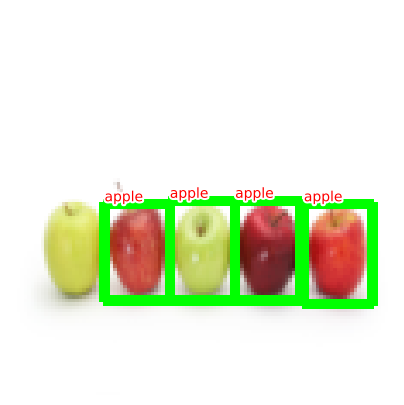

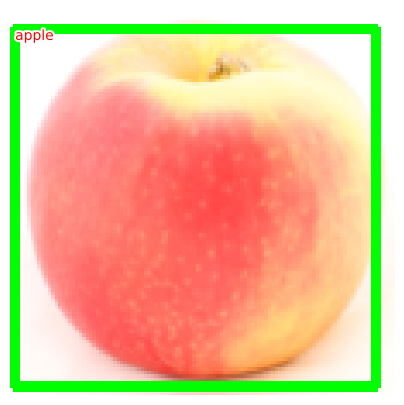

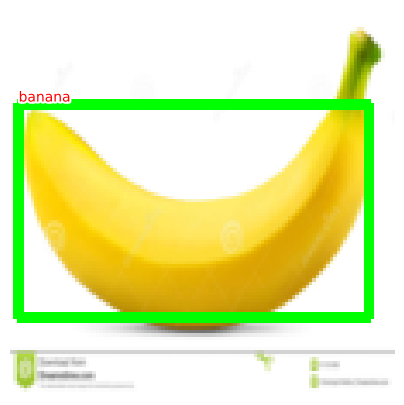

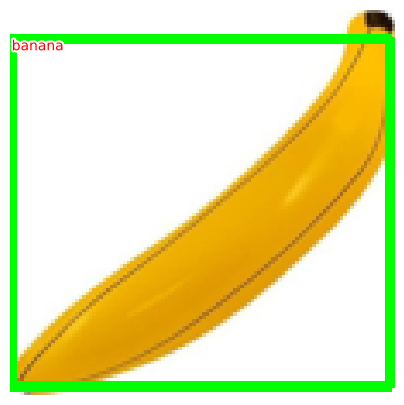

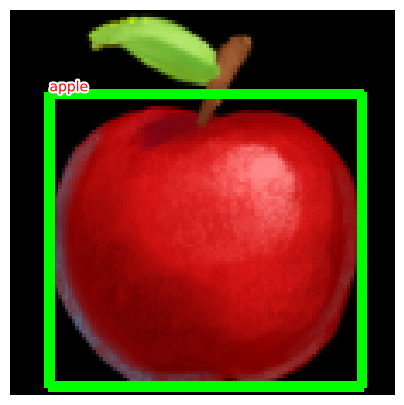

In [71]:
from torchvision.ops import nms


def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    if i == 10: break
    images = [im for im in images]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        show(images[i].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5, text_sz=10)

